In [1]:
from empirical_learning.historical_learning import perform_historical_learning
from empirical_learning.utils import *
from empirical_learning.plot_functions import *
import yfinance as yf

For a given volatility index $v$ and a market index $S$, for a given `setting` which is a list of tuples `(n,j)` or `(n, (j_1,..., j_k))`, for each timestep $t$ (in days):
$$
r_t = \frac{S_t - S_{t-1}}{S_{t-1}}
$$
$$
R_{n,t} = \sum_{t_i \leq t} K_i(t-t_i)r_{t_i}^n
$$

Then the model estimates the volatility as
$$
v_t^p = \beta_0 + \sum_{i} \sum_{j\in\{j_1,\dots, j_{i_k}\}} \beta_{n,j} R_{n,t}^j
$$
Note: when there is only one $j$ associated to $i$, $\beta_{i,j}$ is simply noted $\beta_i$.


For example, the linear model we suggest is defined with `p=1`, `setting=[(1,1), (2,1/2)]`, resulting in
$$
v_t = \beta_0 + \beta_1 R_{1,t} + \beta_2 R_{2,t}^{1/2}
$$
The model (M3) is defined by `p=2`, `setting=[(1,(1,2))]`, resulting in
$$
v_t = \beta_0 + \beta_{1,1} R_{1,t} + \beta_{1,2} R_{1,t}^2
$$

Note that there is one kernel per $i$. The kernels are either time-shifted power-laws or convex combinations of two exponentials.

In [2]:
load_from = pd.to_datetime('1995-01-01')
train_start_date = pd.to_datetime('2000-01-01')  # pd.to_datetime('2008-01-01')
test_start_date = pd.to_datetime('2019-01-01')
test_end_date = pd.to_datetime('2022-05-15')

In [3]:
# Load data on SPX and VIX
spx_data = yf.Ticker("^GSPC").history(start=load_from, end=test_end_date)
vix_data = yf.Ticker("^VIX").history(start=load_from, end=test_end_date)

In [4]:
spx_data.index = pd.to_datetime(spx_data.index.date)
vix_data.index = pd.to_datetime(vix_data.index.date)

In [5]:
spx = spx_data['Close']

In [6]:
vix = vix_data['Close'] / 100

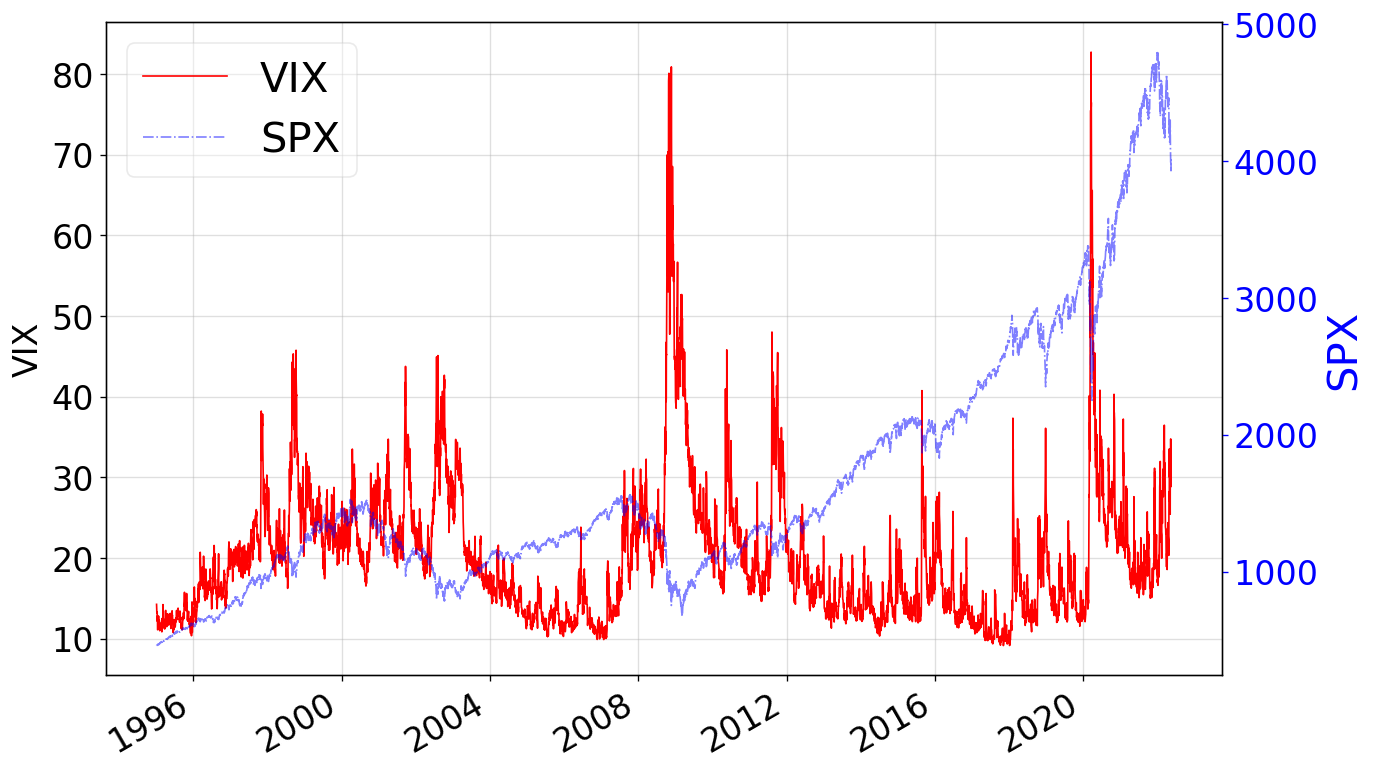

In [7]:
# Plot data
fig = plot_timeseries(100*vix, label='VIX', secondary=spx, secondary_label='SPX', 
                      add_hline=False, color_secondary='b', display_score=False)

In [8]:
# A dictionary of settings are given in MODELS
max_delta = 1000  # Number of past returns used in the computation of R_{n,t} in business days
test_start = test_start_date
test_end = test_end_date
train_start = train_start_date
tspl = False # if True, use time-shifted power-law kernels. Otherwise, use a convex combination of two exponentials

In [9]:
# Next cell runs in about 1-3 minutes if tspl=True, up to 10 minutes if tspl=False
p = 1
setting = [(1, 1), (2, 1/2)] # Our Linear Model
sol = perform_historical_learning(vol=vix, index=spx, p=p, tspl=tspl, setting=setting, train_start_date=train_start,
                                  test_start_date=test_start, test_end_date=test_end, 
                                  max_delta=max_delta)

The parameters and scores will be different than the one presented in the paper. This is because we could only find 10 years of SPX publicly available on the internet

In [10]:
# Computed optimal parameters
sol['opt_params']

{'beta_0': 0.05431907078829664,
 'theta_1': 0.8101658085631585,
 'lambda_1': array([52.69878387, 17.2437368 ]),
 'beta_1': -0.07789648173387251,
 'theta_2': 0.43008970008778785,
 'lambda_2': array([3.78857201, 1.15759303]),
 'beta_2': 0.821367161202075}

In [11]:
# scores
print({key: sol[key] for key in ['train_r2', 'test_r2', 'train_rmse', 'test_rmse']})

{'train_r2': 0.9471796382896874, 'test_r2': 0.867547810167539, 'train_rmse': 0.0198019043610705, 'test_rmse': 0.033672588791173956}


In [12]:
# plot timeseries of predictions vs true
pred_on_test = sol['test_pred']
pred_on_train = sol['train_pred']
target_on_test = data_between_dates(vix, start_date=test_start_date, end_date=test_end_date)
target_on_train = data_between_dates(vix, start_date=train_start_date, end_date=test_start_date)
index_on_test = data_between_dates(spx, start_date=test_start_date, end_date=test_end_date)
index_on_train = data_between_dates(spx, start_date=train_start_date, end_date=test_start_date)

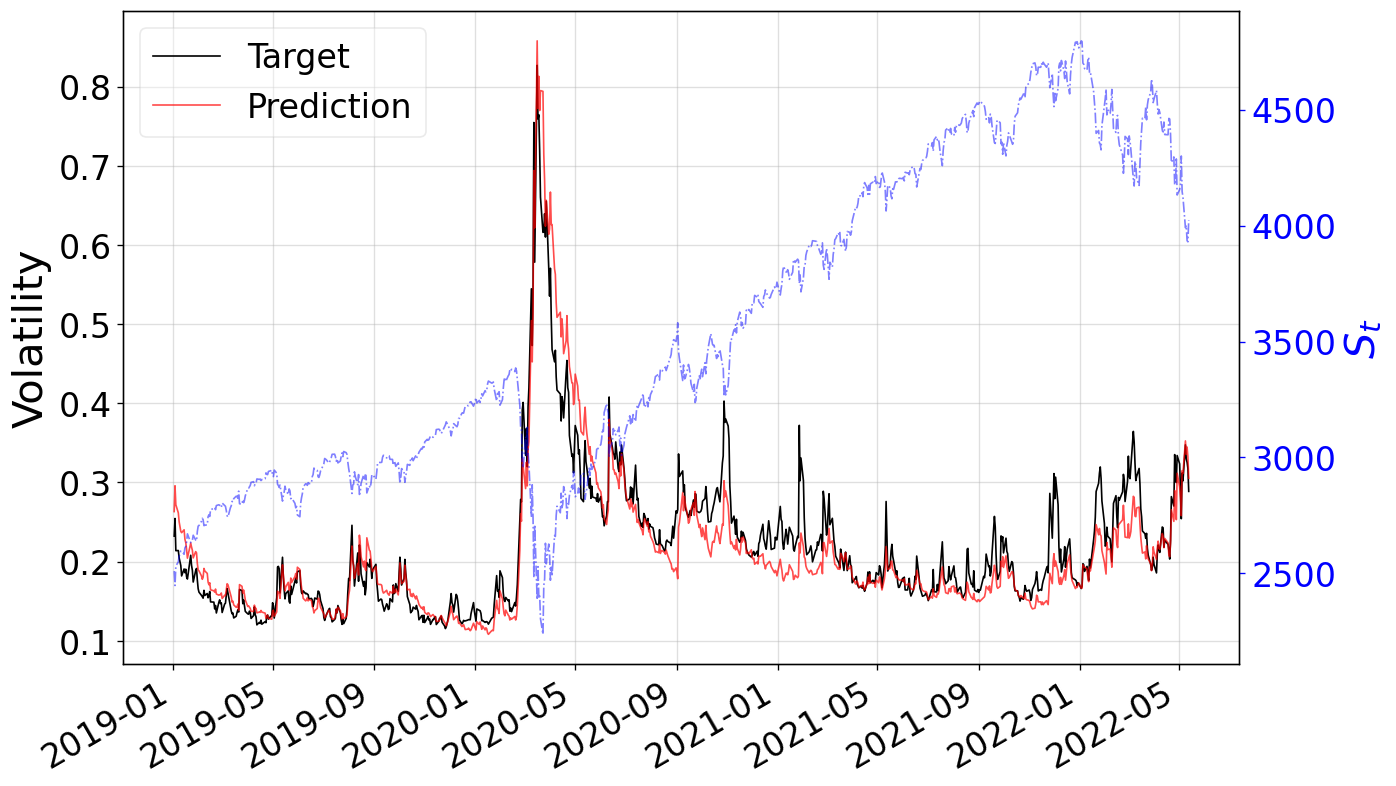

In [13]:
fig = plot_prediction_timeseries(y_target=target_on_test, y_pred=pred_on_test, index=index_on_test)

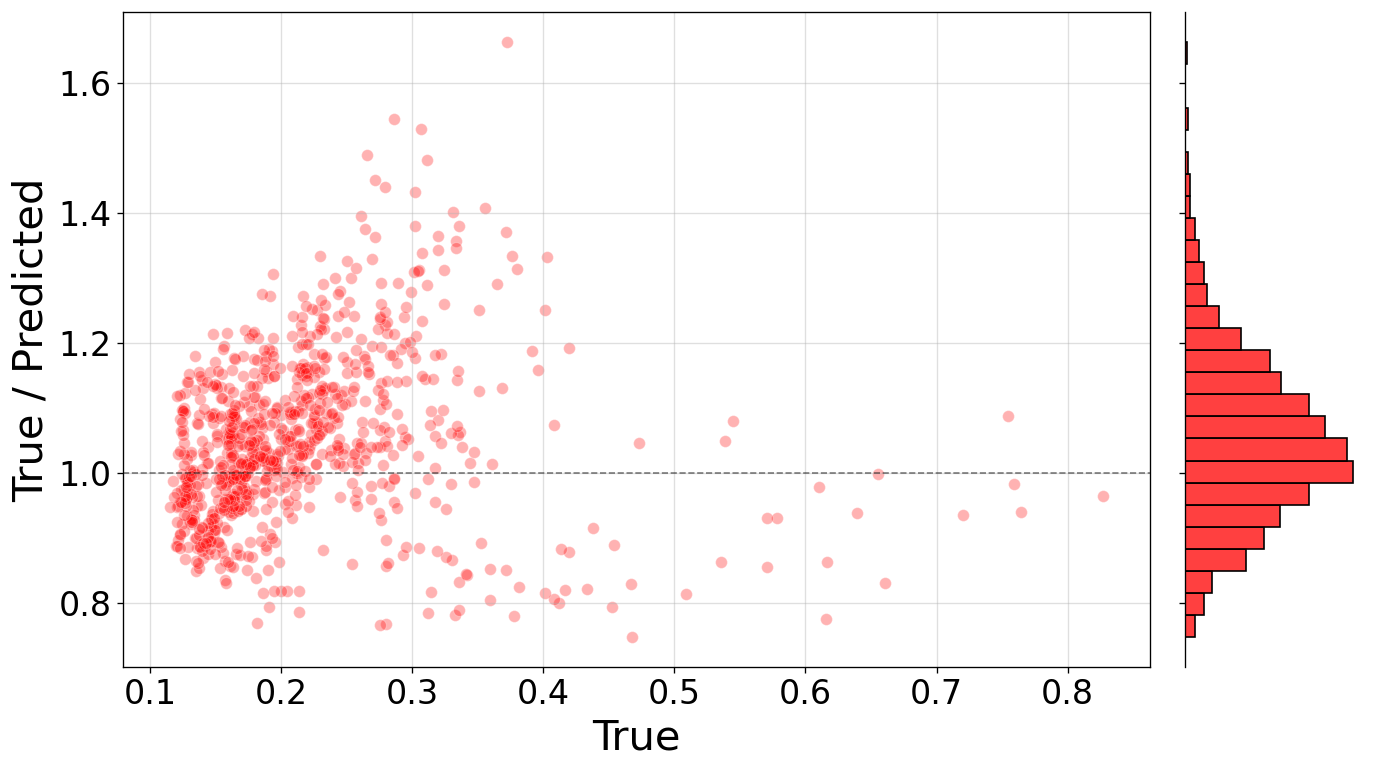

In [14]:
# Plot residuals on train set
fig = plot_prediction_vs_true(y_pred=pred_on_test, y_target=target_on_test, plot_residuals=True, ratio_residuals=True)

In [15]:
target_on_train

2000-01-03    0.2421
2000-01-04    0.2701
2000-01-05    0.2641
2000-01-06    0.2573
2000-01-07    0.2172
               ...  
2018-12-24    0.3607
2018-12-26    0.3041
2018-12-27    0.2996
2018-12-28    0.2834
2018-12-31    0.2542
Name: Close, Length: 4779, dtype: float64

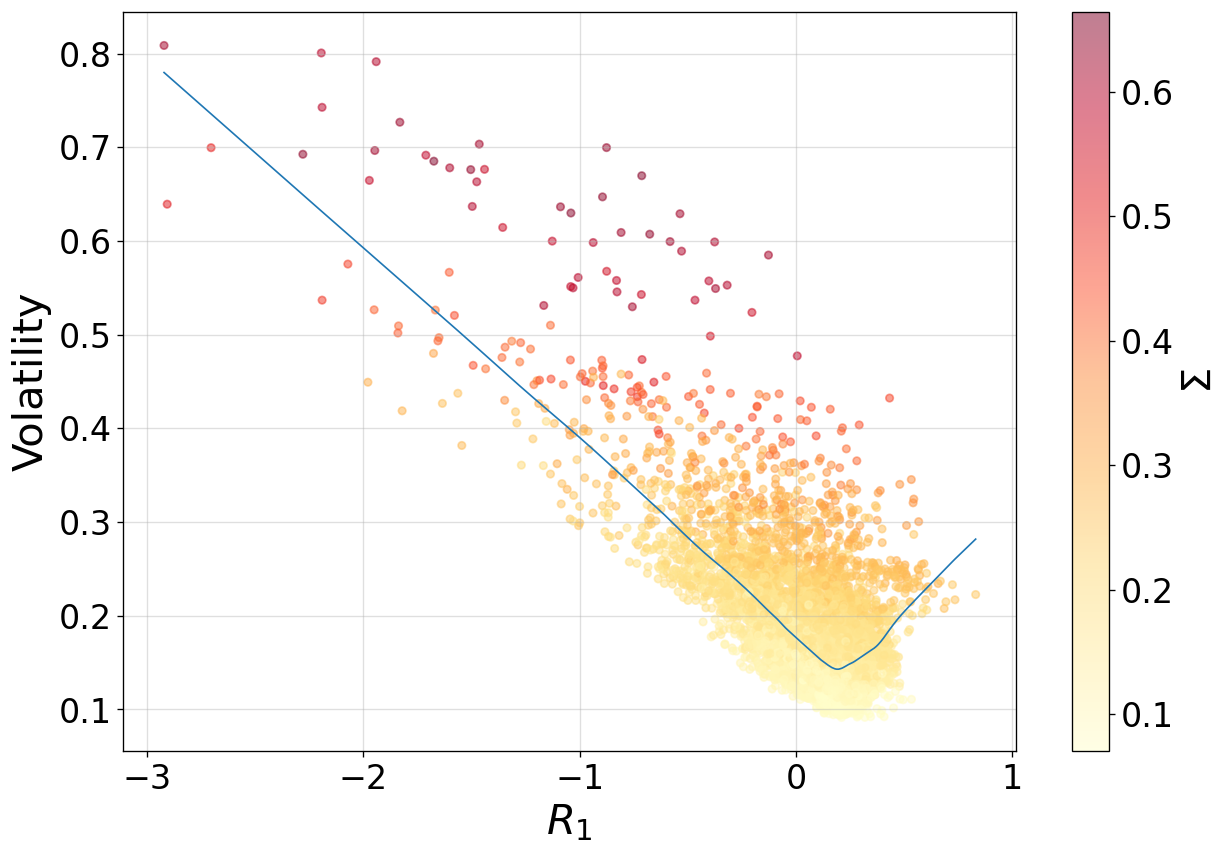

In [16]:
### Target vs Features
r_1_train = data_between_dates(sol['features']['R_1'], start_date=train_start_date, end_date=test_start_date)
sigma_train =  data_between_dates(sol['features']['R_2^0.5'], start_date=train_start_date, end_date=test_start_date)
fig = plot_vol_against_feature(feature=r_1_train, target=target_on_train, color_variable=sigma_train, 
                               color_label='$\Sigma$', feature_name='$R_1$')